In [1]:
# To use louvain algorithm
!pip3 install python-louvain
# To use progressbar
!pip3 install progressbar2

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [8]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict,Counter
import progressbar
import random
import itertools 
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import f1_score

In [9]:
# Weighted version!
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    i = 0
    tmlist = list(findAllFile(tm_folder))
    tmlist.sort()
    cllist = list(findAllFile(cl_folder))
    cllist.sort()
    for tm,cl in zip(tmlist,cllist):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.asmatrix(np.loadtxt(tm,delimiter=","))
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        #AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        #epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        #AM[OM >= epsilon] = 1
        #AM[OM < epsilon] = 0 
        #np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and no-weight graph
        #G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Get weighted adjacency matrix
        # load original matrix from csv and process it to be an adjacency Matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # consider if there is an edge between two cows, the edge is weighted
        maxnr=np.amax(OM)
        AM=np.where(OM<=epsilon,0,(OM-epsilon)/(maxnr-epsilon))
        np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and weighted graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Make sure the order of cowlist is the same as the row name!
        print('Shape of matrix:',AM.shape)
        print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
        mapping = dict(zip(G_AM_temp, cowlist))
        #print(mapping)
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_weighted,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_weighted=AM,Graph=G_AM)
        print('Document No.',i)
        print('TM path:',tm,'CL path:',cl)
        i = i + 1
        dict_list.append(data_dict)

    print('The length of the list: ',len(dict_list))
    return dict_list

In [24]:
def community_Louvain(i,G):
    #print('This is the result of day %d'%(i+1))
    
    # Remove the nodes whose degree is zero
    nodes_removed = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(nodes_removed)
    #print(len(nodes_removed),'nodes whose degree is zero are removed')
    
    # Louvain algorithm
    partition = community.best_partition(G,weight = 'weight',randomize=False)
    if (len(partition.values())==0):
        return 0,0,0
    num_communities = max(partition.values())
    
    # create a dict object:{community1:[nodelist],community2:[nodelist],......}
    # community1:[nodelist] is a tuple
    communities_Louvain = defaultdict(list) 
    for k, v in partition.items():
        communities_Louvain[v].append(k)    
    np.save('./community/Louvain_weighted/Day_%d_Louvain_weighted_communities.npy'%(i+1), communities_Louvain)
    
    #read the dict from file
    #communities_Louvain = np.load('./community/Louvain/Day_%d_Louvain_Unweighted_communities.npy', allow_pickle='TRUE')
    #print(communities_Louvain)

    len_Louvain = len(communities_Louvain)
    #print('max No. of community:',num_communities)
    print('num of communities:',len_Louvain)
    print('Modularity:',nx.algorithms.community.quality.modularity(G,communities_Louvain.values()))

    # Colormap for plotting
    color_Louvain = 0
    random.seed(7)
    total_colors = list(mpl.colors.get_named_colors_mapping())
    total_colors.remove('black')
    color_map_Louvain = random.sample(total_colors,len_Louvain)

    # Plot the figure
    plt.figure(figsize=(15, 15))  # image size
    pos = nx.fruchterman_reingold_layout(G, scale = 1) # position of nodes
    degree_dict = dict(G.degree())
    nx.draw_networkx(G, pos, node_size=5,width=0.05, alpha=1, with_labels=False)
    for community_Louvain in communities_Louvain.items():
        
        node_list = community_Louvain[1]
        edge_list = list(itertools.chain.from_iterable([list(G.edges(node)) for node in node_list]))
        label_list = {}
        for node in node_list:
            #set the node name as the key and the label as its value 
            label_list[node] = node 
        community_degree_dict = {key: value for key, value in degree_dict.items() if key in node_list}
        node_size_list = [d*20 for d in community_degree_dict.values()]
        
        nx.draw_networkx_nodes(G, pos , nodelist = node_list, node_size = node_size_list, node_color = color_map_Louvain[color_Louvain],alpha = 0.7)
        nx.draw_networkx_edges(G, pos , edgelist = edge_list, edge_color = color_map_Louvain[color_Louvain],alpha = 0.2)
        nx.draw_networkx_labels(G, pos, label_list, font_size = 8, font_color = color_map_Louvain[color_Louvain],alpha = 0.7)
        color_Louvain += 1
    plt.savefig('./community/Louvain_weighted/Day%d_weighted_Community.png'%(i+1))
    #plt.show()
    
    return nodes_removed, communities_Louvain, partition

In [11]:
def compute_NMI(p1,p2):
    list1 = []
    list2 = []
    dict1 = {}
    dict2 = {}
    key1set = set(sorted(p1))
    key2set = set(sorted(p2))
    keylist = list(key1set&key2set)
    keylist.sort()
    #print(len(key1set))
    #print(len(key2set))
    #print(len(keylist))
    i = 0
    for key in keylist:
        list1.append(p1.get(key,-1))
        list2.append(p2.get(key,-1))
        dict1[key] = p1.get(key,-1)
        dict2[key] = p2.get(key,-1)
        #i = i+1
        #print(i,key)
    #print(list1)
    #print(list2)
    return normalized_mutual_info_score(list1,list2), adjusted_mutual_info_score(list1,list2), f1_score(list1,list2, average='weighted')

In [12]:
def create_rand_adjacency(day):
    # create a random adjacency matrix of a specific day
    # compute the density
    graph = data_dict_list[day-1].get('Graph')
    density = nx.classes.function.density(graph)
    # create a basic matrix has the density
    AM = data_dict_list[day-1].get('AM_weighted')
    AM_rand = np.random.rand(AM.shape[0]*AM.shape[1]).reshape((AM.shape))
    AM_temp = np.zeros((AM_rand.shape))
    AM_temp[AM_rand <= density] = 1
    AM_temp[AM_rand > density] = 0

    # unweighted
    AM_up = np.triu(AM_temp)
    np.fill_diagonal(AM_up,0)
    AM_unweighted_rand = AM_up + AM_up.T

    # weighted
    AM_weighted_up = np.zeros((AM_up.shape))
    row,col = np.where(AM_up == 1)
    for i,j in zip(row,col):
        if AM_up[i][j] == 1:
            AM_weighted_up[i][j] = np.random.rand(1)
        else:
            pass
    AM_weighted_rand = AM_weighted_up + AM_weighted_up.T
    
    return AM_unweighted_rand, AM_weighted_rand 

In [13]:
# This part is used to process the time matrices
tm_folder = './area_divided_time_matrix/Time in Robot area'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)

Shape of matrix: (213, 213)
number of nodes in graph 213 length of cowlist 213
Document No. 0
TM path: ./area_divided_time_matrix/Time in Robot area\Time_Robot_FA_20201016T000000UTC.csv CL path: ./cow_list\Cow_list_20201016T000000UTC.csv
Shape of matrix: (212, 212)
number of nodes in graph 212 length of cowlist 212
Document No. 1
TM path: ./area_divided_time_matrix/Time in Robot area\Time_Robot_FA_20201017T000000UTC.csv CL path: ./cow_list\Cow_list_20201017T000000UTC.csv
Shape of matrix: (219, 219)
number of nodes in graph 219 length of cowlist 219
Document No. 2
TM path: ./area_divided_time_matrix/Time in Robot area\Time_Robot_FA_20201018T000000UTC.csv CL path: ./cow_list\Cow_list_20201018T000000UTC.csv
Shape of matrix: (208, 208)
number of nodes in graph 208 length of cowlist 208
Document No. 3
TM path: ./area_divided_time_matrix/Time in Robot area\Time_Robot_FA_20201019T000000UTC.csv CL path: ./cow_list\Cow_list_20201019T000000UTC.csv
Shape of matrix: (209, 209)
number of nodes in g

In [25]:
# Louvain algorithm
partition_14days = []
Louvain_community_14days = []
nodes_removed_14days = []
bar = progressbar.ProgressBar()
# from 0 to 13
for i in bar(range(0,len(data_dict_list))):
    nodes_removed_1day, Louvain_community_1day, partition_1day = community_Louvain(i,data_dict_list[i].get('Graph'))
    nodes_removed_14days.append(nodes_removed_1day)
    Louvain_community_14days.append(Louvain_community_1day)
    partition_14days.append(partition_1day)

100% (14 of 14) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [26]:
#real day j vs real day j+1
bar = progressbar.ProgressBar()
print('Weighted graph(Louvain)')
for j in bar(range(1,len(data_dict_list))):
    print('Real Day %d and Real Day %d :NMI is'%(j,j+1),compute_NMI(partition_14days[j-1],partition_14days[j]))

  0% (0 of 13) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Weighted graph(Louvain)


TypeError: 'int' object is not iterable

Weighted graph(Louvain)
num of communities: 13
Modularity: 0.4990369026650706
----------
Real Day 1 and Real Day 2 :NMI is (0.16232774219562413, 0.0006659772442209571, 0.07245528182165167)
Random Day 1 and Real Day 2 :NMI is (0.16875577094074629, -0.0004973062925292679, 0.09109014840741671)
num of communities: 11
Modularity: 0.4453553840919747
----------
Real Day 2 and Real Day 3 :NMI is (0.18400087078466915, 0.021856336936454866, 0.06712447704209439)
Random Day 2 and Real Day 3 :NMI is (0.12548296919714813, -0.014262161984663452, 0.09367452988647514)
num of communities: 11
Modularity: 0.44142118824220483
----------
Real Day 3 and Real Day 4 :NMI is (0.12981023857760873, -0.018166151595641958, 0.08130356209432525)
Random Day 3 and Real Day 4 :NMI is (0.12358218437947159, -0.0022285841194178927, 0.11479985805076907)
num of communities: 11
Modularity: 0.4262207860293551
----------
Real Day 4 and Real Day 5 :NMI is (0.17377859669701692, 0.013581378253900083, 0.08244754266259643)
Random Da

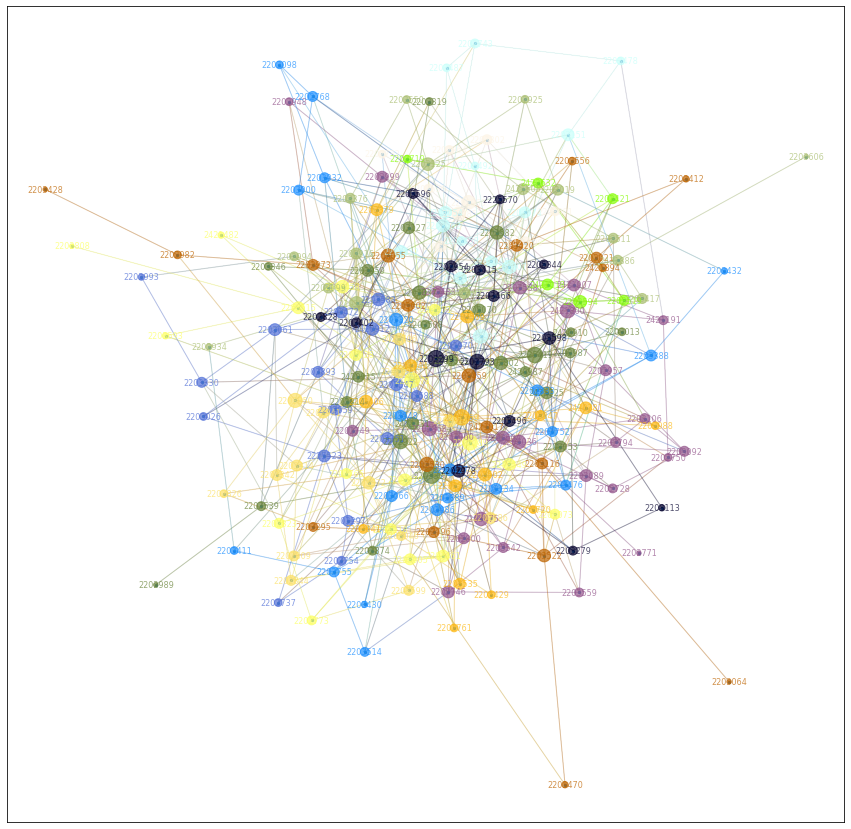

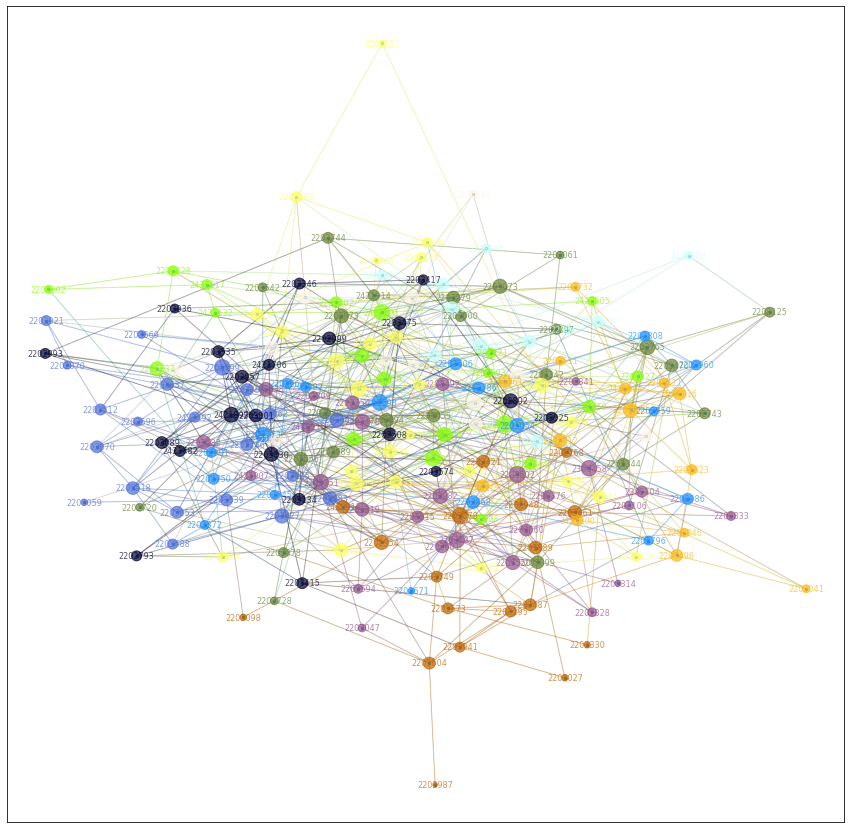

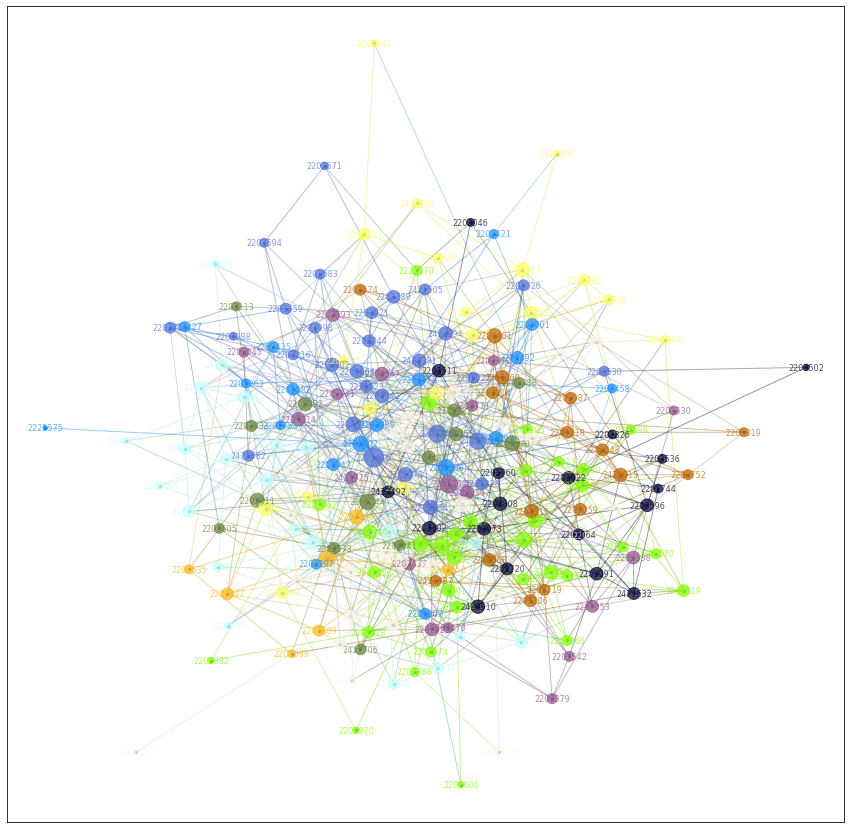

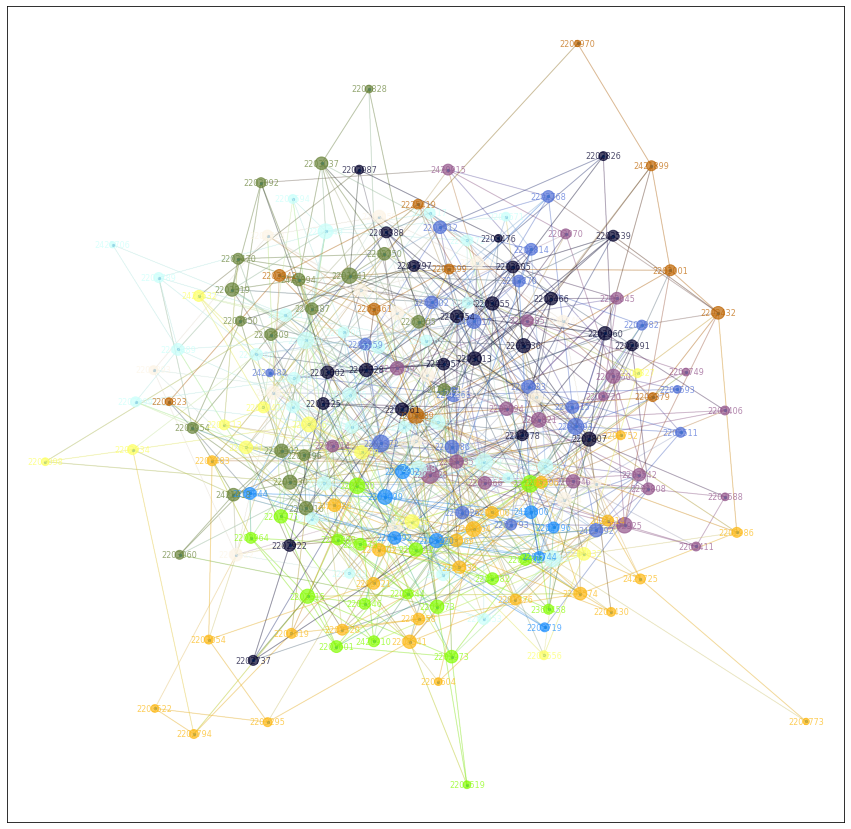

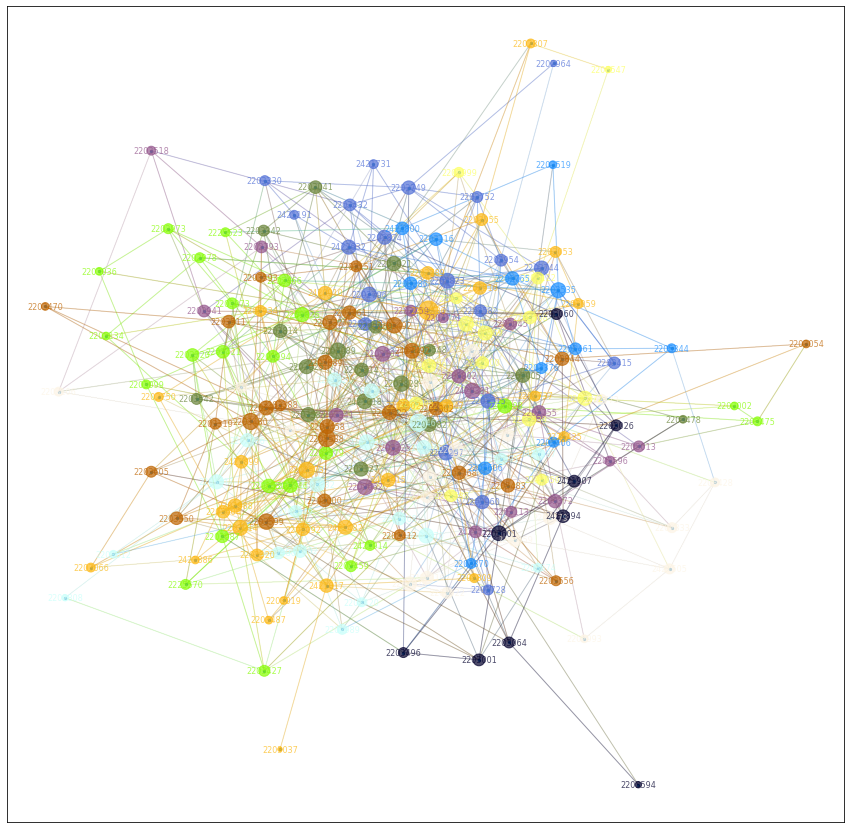

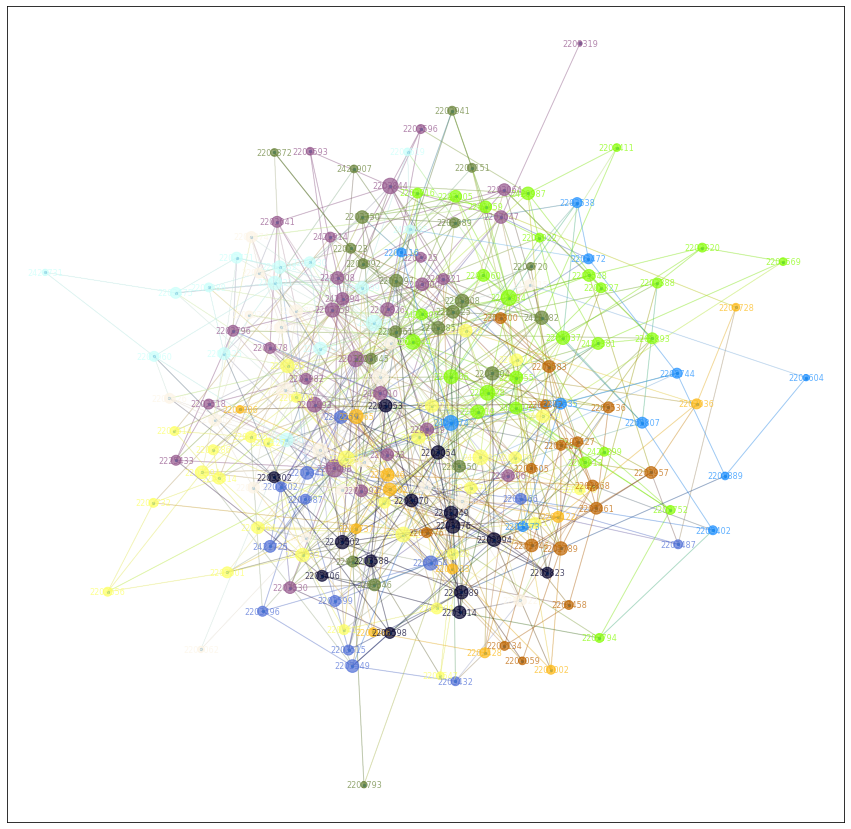

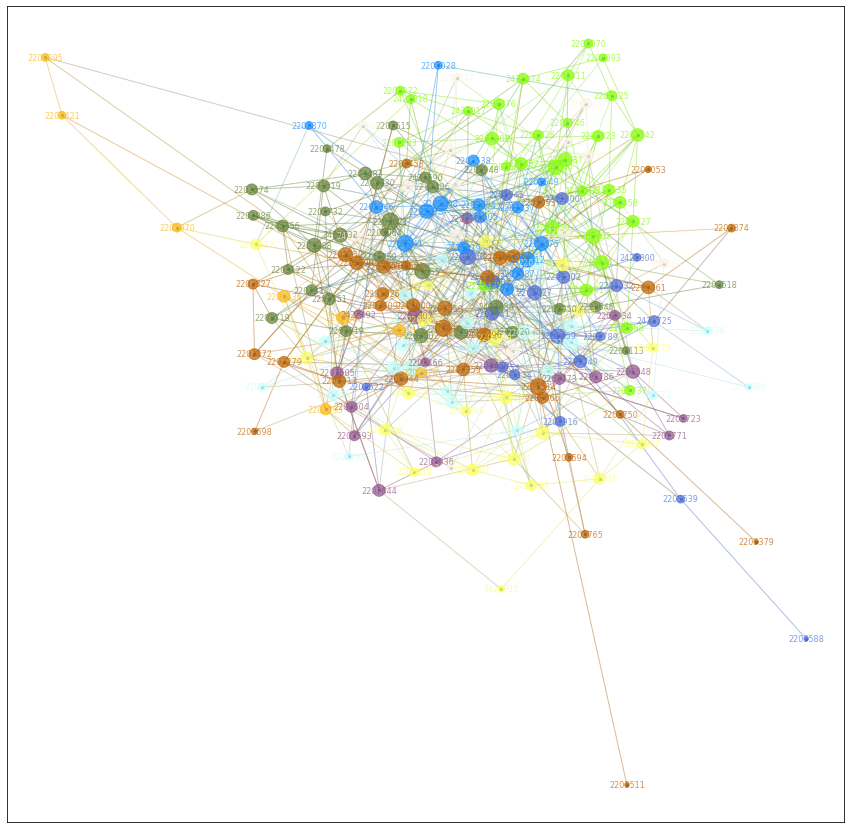

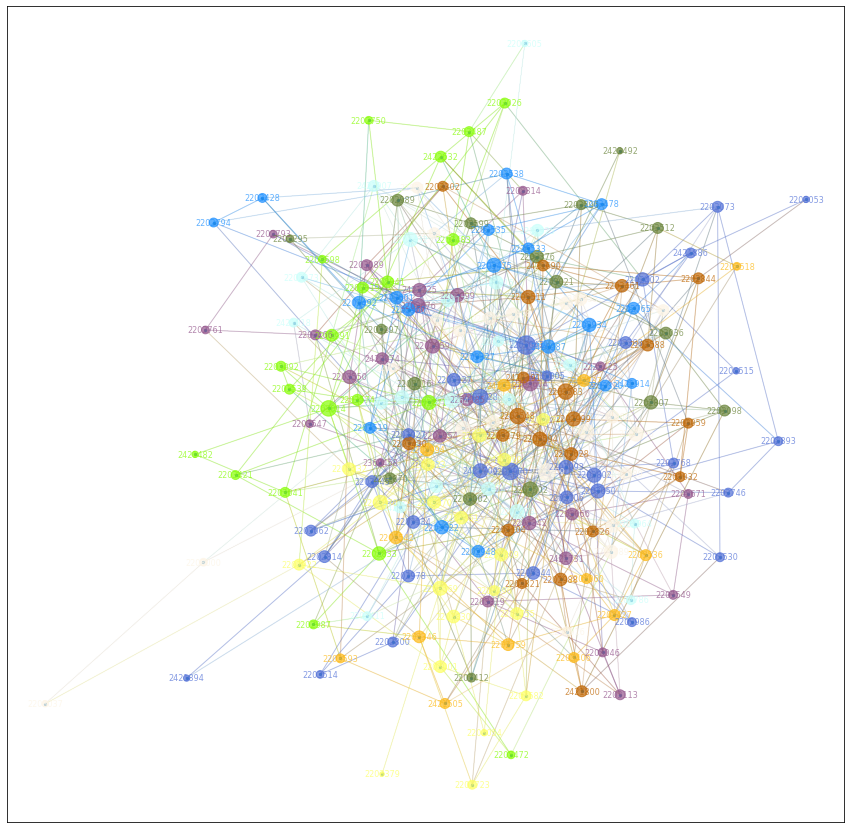

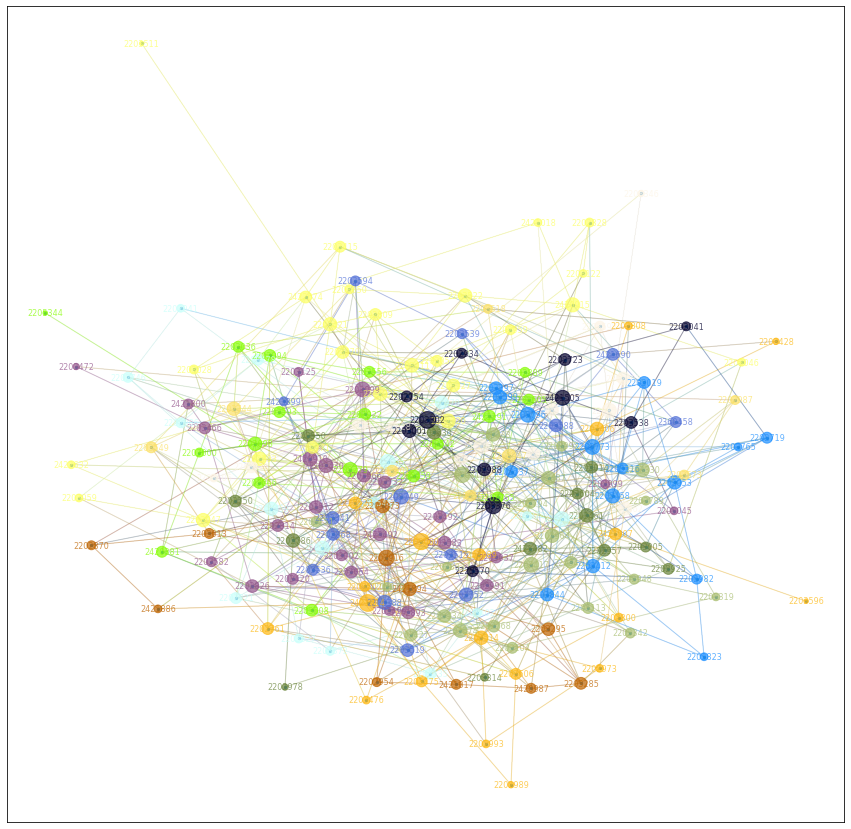

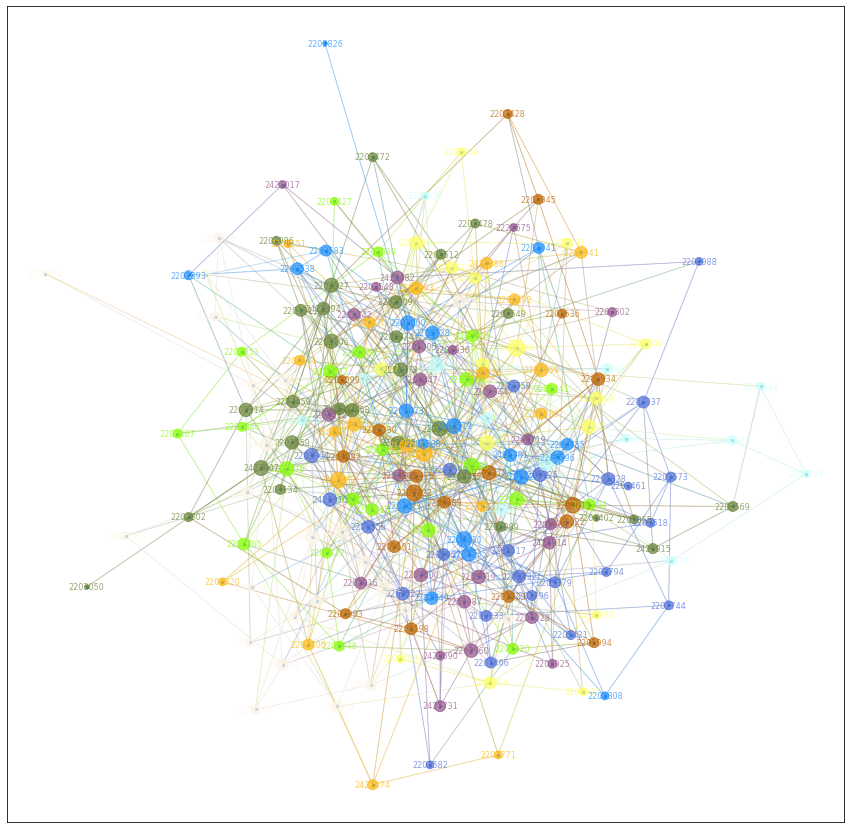

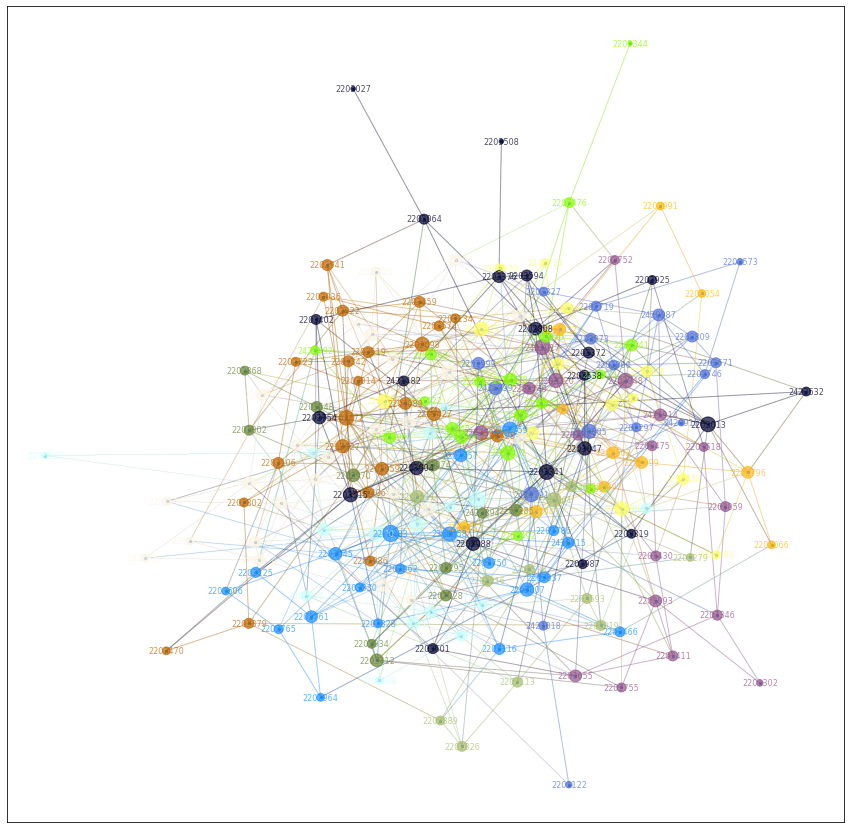

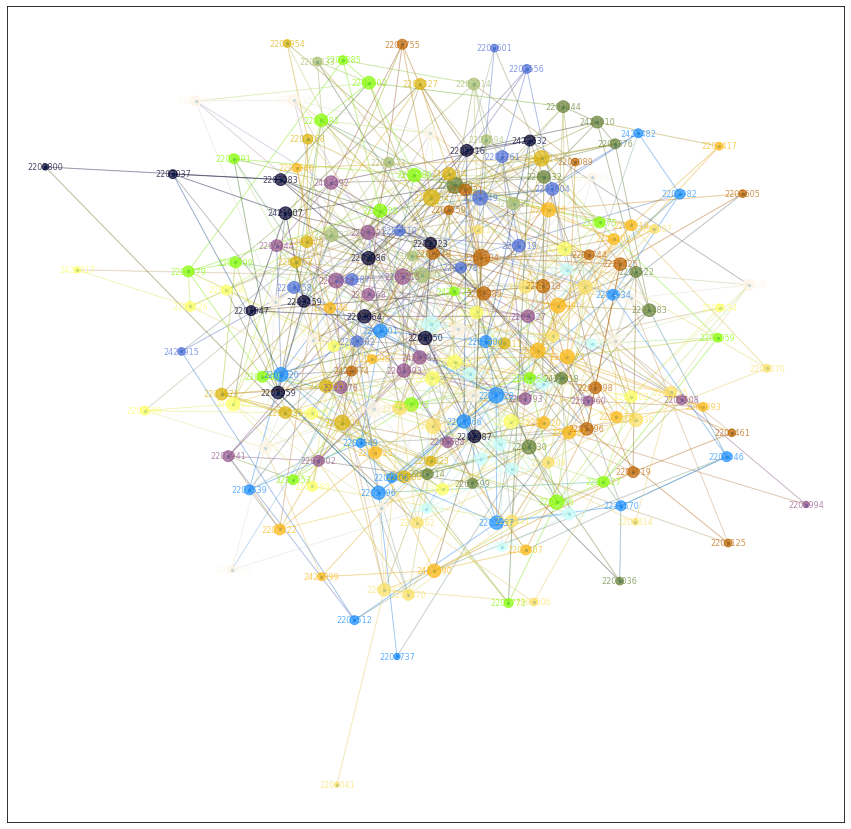

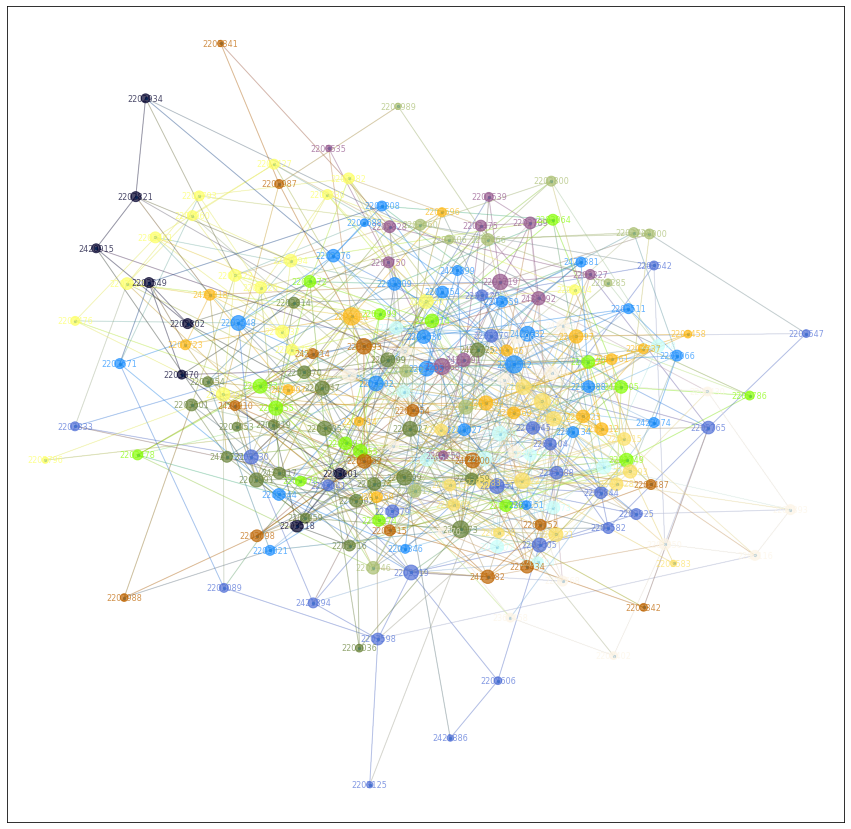

In [11]:
#random day j vs real day j+1
#bar = progressbar.ProgressBar()
print('Weighted graph(Louvain)')
for j in range(1,len(data_dict_list)):
    # random graph of one day(have the same density)
    uwr,wr = create_rand_adjacency(j)
    # Get graph from AM, no-direct and weighted graph
    G_AM_temp = nx.from_numpy_matrix(wr,parallel_edges=False,create_using = nx.Graph())
    cowlist = data_dict_list[j-1].get('CL')
    # Make sure the order of cowlist is the same as the row name!
    #print('Shape of matrix:',wr.shape)
    #print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
    mapping = dict(zip(G_AM_temp, cowlist))
    #print(mapping)
    # Rename the nodes
    G_AM = nx.relabel_nodes(G_AM_temp, mapping)
    nodes_removed_1day_r, Louvain_community_1day_r, partition_1day_r = community_Louvain(j-1,G_AM)
    print('----------')
    print('Real Day %d and Real Day %d :NMI is'%(j,j+1),compute_NMI(partition_14days[j-1],partition_14days[j]))
    print('Random Day %d and Real Day %d :NMI is'%(j,j+1),compute_NMI(partition_1day_r,partition_14days[j]))

In [10]:
# Random list NMI
bar = progressbar.ProgressBar()
print('Random list NMI')
for j in bar(range(1,len(data_dict_list))):
    np.random.seed()
    list1 = np.random.randint(low = 0, high = 11, size = 210)
    np.random.seed()
    list2 = np.random.randint(low = 0, high = 11, size = 210)
    NMI = normalized_mutual_info_score(list1,list2)
    print('NMI of random test %d'%(j),NMI)

100% (13 of 13) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Random list NMI
NMI of random test 1 0.12848511488343414
NMI of random test 2 0.10584855389888422
NMI of random test 3 0.11161310686592484
NMI of random test 4 0.1255875952527715
NMI of random test 5 0.12276922952441541
NMI of random test 6 0.11463057869457839
NMI of random test 7 0.12833770439570175
NMI of random test 8 0.14836158543223796
NMI of random test 9 0.11913505330994967
NMI of random test 10 0.10926948279876102
NMI of random test 11 0.10532158570694257
NMI of random test 12 0.1482821068044388
NMI of random test 13 0.1497905453762655


# Draft

In [108]:
# The NMI of real day1 and real day2
list1 = []
list2 = []
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_14days[1]))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_14days[1].get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

213
212
209


0.16759813447692676

In [109]:
# The NMI of real day1 and random day1
list1 = []
list2 = []
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

213
213
213


0.10002034976354635

In [107]:
# The NMI of real day2 and random day1
list1 = []
list2 = []
key1set = set(sorted(partition_14days[1]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[1].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

212
213
209


0.10911626405807336

Shape of matrix: (209, 209)
number of nodes in graph 209 length of cowlist 209
This is the result of day 1
0 nodes whose degree is zero are removed
max No. of community: 10
num of communities: 11


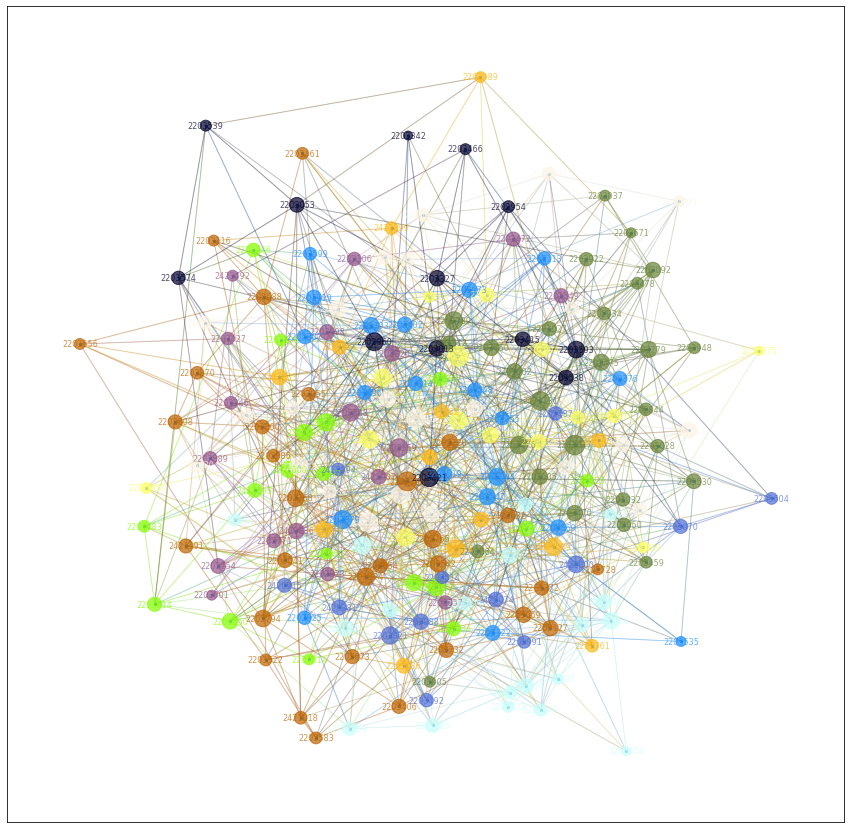

In [129]:
# random graph of day 13
uwr13,wr13 = create_rand_adjacency(13)
# Get graph from AM, no-direct and weighted graph
G_AM_temp = nx.from_numpy_matrix(wr13,parallel_edges=False,create_using = nx.Graph())
cowlist = data_dict_list[12].get('CL')
# Make sure the order of cowlist is the same as the row name!
print('Shape of matrix:',wr13.shape)
print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
mapping = dict(zip(G_AM_temp, cowlist))
#print(mapping)
# Rename the nodes
G_AM = nx.relabel_nodes(G_AM_temp, mapping)
nodes_removed_1day_r, Louvain_community_1day_r, partition_1day_r = community_Louvain(0,G_AM)

In [130]:
# The NMI of real day13 and random day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[12]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[12].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

209
209
209


0.10103606922899405

In [131]:
# The NMI of real day14 and random day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[13]))
key2set = set(sorted(partition_1day_r))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[13].get(key,-1))
    list2.append(partition_1day_r.get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

205
209
203


0.09870384031139294

In [132]:
# The NMI of real day14 and real day13
list1 = []
list2 = []
key1set = set(sorted(partition_14days[13]))
key2set = set(sorted(partition_14days[12]))
keylist = list(key1set&key2set)
print(len(key1set))
print(len(key2set))
print(len(keylist))
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[13].get(key,-1))
    list2.append(partition_14days[12].get(key,-1))
    #i = i+1
    #print(i,key)
#print(list1)
#print(list2)
normalized_mutual_info_score(list1,list2)

205
209
203


0.08513804325752647

In [8]:
# check the first day community
for c,n in Louvain_community_14days[0].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

community 5
number of nodes in community 27
[2202759, 2202771, 2202814, 2202889, 2202988, 2202989, 2202994, 2203032, 2203055, 2203116, 2203122, 2203330, 2203341, 2203346, 2203379, 2203412, 2203417, 2203461, 2203466, 2203470, 2203487, 2203530, 2203593, 2203599, 2225570, 2420910, 2421800]
community 3
number of nodes in community 21
[2202737, 2202744, 2202868, 2202925, 2202970, 2202993, 2203001, 2203050, 2203053, 2203062, 2203089, 2203319, 2203458, 2203492, 2203515, 2203522, 2203535, 2203550, 2203556, 2203606, 2421191]
community 6
number of nodes in community 12
[2202732, 2202754, 2202808, 2203372, 2203376, 2203415, 2203512, 2203518, 2421482, 2421899, 2422632, 2423492]
community 0
number of nodes in community 36
[2202743, 2202821, 2202870, 2202954, 2202959, 2202982, 2203026, 2203028, 2203037, 2203045, 2203061, 2203073, 2203098, 2203106, 2203125, 2203127, 2203134, 2203299, 2203302, 2203314, 2203342, 2203421, 2203475, 2203476, 2203496, 2203514, 2203548, 2203583, 2203588, 2203596, 2203604, 2

In [9]:
for c,n in Louvain_community_14days[1].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

community 9
number of nodes in community 22
[2202671, 2202732, 2202786, 2202794, 2202925, 2202973, 2202978, 2203002, 2203054, 2203061, 2203066, 2203125, 2203372, 2203411, 2203483, 2203583, 2203594, 2203596, 2360458, 2421505, 2421706, 2421725]
community 1
number of nodes in community 12
[2202800, 2202809, 2202948, 2203299, 2203327, 2203406, 2203427, 2203430, 2203472, 2203487, 2421017, 2421914]
community 2
number of nodes in community 26
[2202720, 2202765, 2202796, 2202814, 2202959, 2203000, 2203060, 2203064, 2203070, 2203127, 2203279, 2203295, 2203314, 2203379, 2203415, 2203428, 2203459, 2203466, 2203492, 2203569, 2203573, 2203593, 2203605, 2421018, 2421899, 2423492]
community 0
number of nodes in community 10
[2202999, 2203001, 2203028, 2203041, 2203050, 2203098, 2203342, 2203496, 2203542, 2421191]
community 4
number of nodes in community 11
[2202802, 2203014, 2203046, 2203421, 2203475, 2203502, 2203530, 2203582, 2420381, 2420915, 2421894]
community 5
number of nodes in community 20
[2

In [ ]:
'''
def compute_NMI(day1,day2):
    list1 = list(partition_14days[day1-1].values())
    list2 = list(partition_14days[day2-1].values())
    if len(list1)<len(list2):
        rand = np.random.randint(low = 0, high = max(list1)+1, size = len(list2)-len(list1))
        list1.extend(rand)
    elif len(list2)<len(list1):
        rand = np.random.randint(low = 0, high = max(list2)+1, size = len(list1)-len(list2))
        list2.extend(rand)
    else:
        pass
    print(len(list1),len(list2))
    return normalized_mutual_info_score(list1,list2)
'''

In [ ]:
'''
Draft
rand = np.random.randint(low = 0, high = max(partition_14days[0].values())+1, size = 1)
print(partition_14days[0].get(999,rand[0]))
list1=[]
list2=[]
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_14days[1]))
keylist = list(key1set&key2set)
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_14days[1].get(key,-1))
    #i = i+1
    #print(i,key)
normalized_mutual_info_score(list1,list2)
'''